In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os, glob

In [3]:
dataset_path = "/content/drive/My Drive/Semester2/ComputerVision/Tugas2/Dataset"
template_path = "/content/drive/My Drive/Semester2/ComputerVision/Tugas2/template.jpg"
output_dir = "/content/drive/My Drive/Semester2/ComputerVision/Tugas2/Deteksi" #Membuat folder output
os.makedirs(output_dir, exist_ok=True)

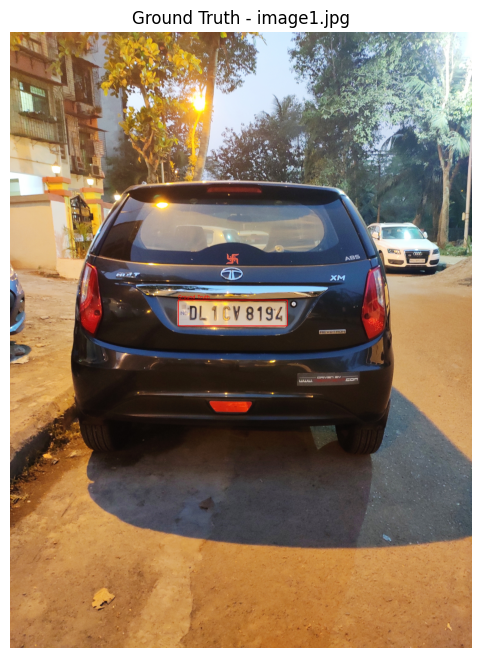

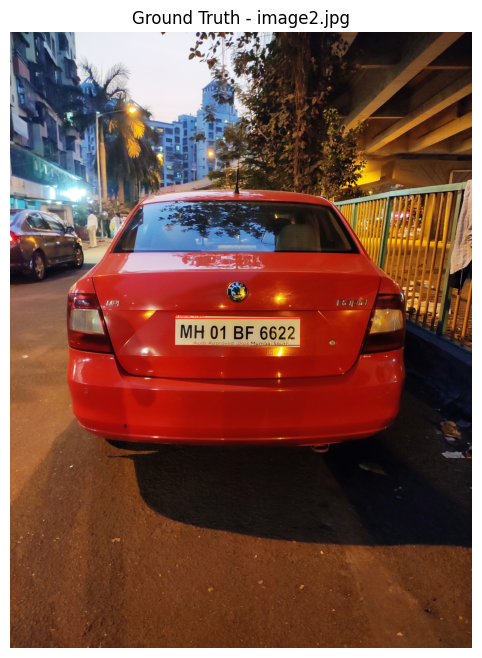

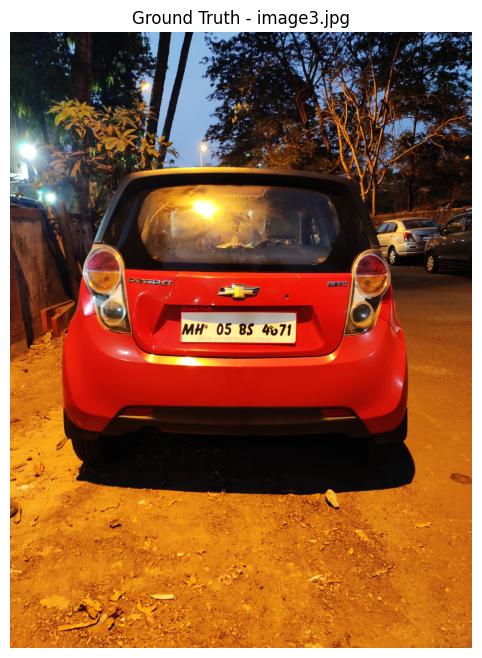

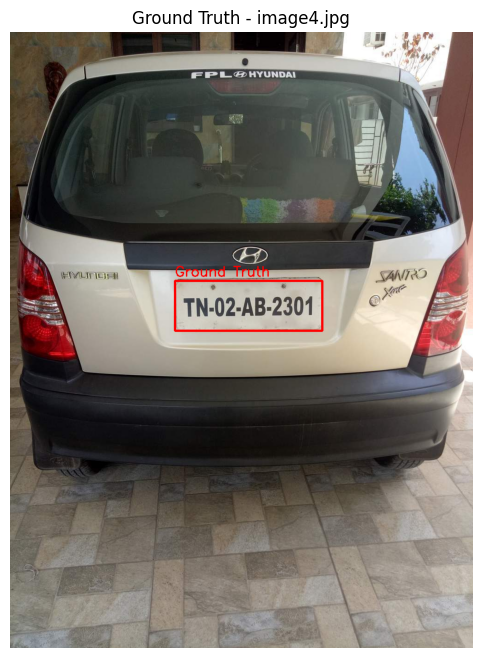

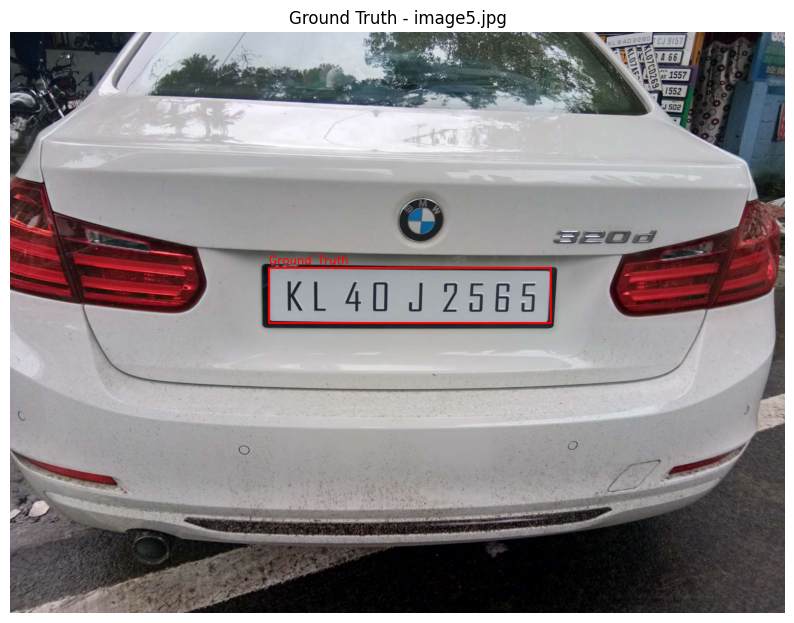

In [4]:
#Gambar Ground Truth
ground_truth = {
    "image1.jpg": (1092, 1740, 708, 168),
    "image2.jpg": (1062, 1860, 828, 174),
    "image3.jpg": (1110, 1818, 750, 204),
    "image4.jpg": (356, 538, 318, 108),
    "image5.jpg": (668, 610, 727, 142),
}
# --- Menampilkan semua gambar dengan kotak ground truth ---
for filename, (x, y, w, h) in ground_truth.items():
    img_path = os.path.join(dataset_path, filename)
    image = cv2.imread(img_path)
    if image is None:
        print(f"Gagal membaca {filename}")
        continue

    # Gambar kotak ground truth (merah)
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 4)
    cv2.putText(image, "Ground Truth", (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    # Tampilkan
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Ground Truth - {filename}")
    plt.axis("off")
    plt.show()

#Mengubah Template menjadi Grayscale
template = cv2.imread(template_path, 0)






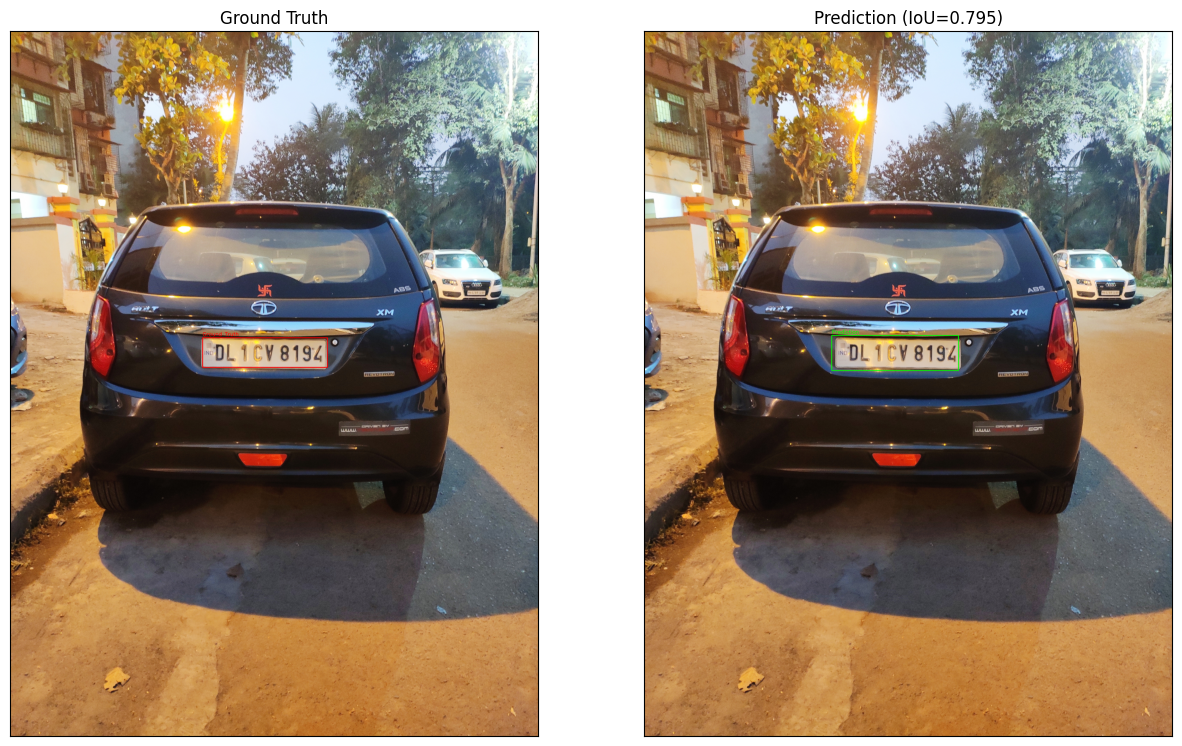

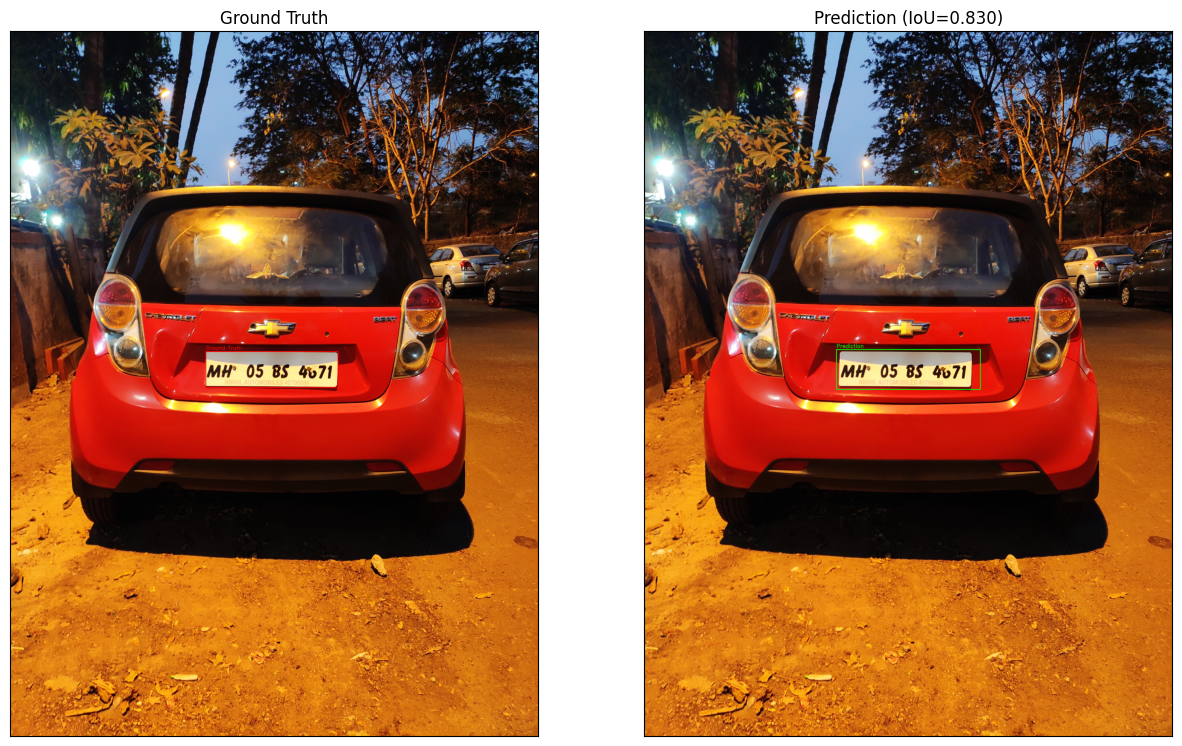

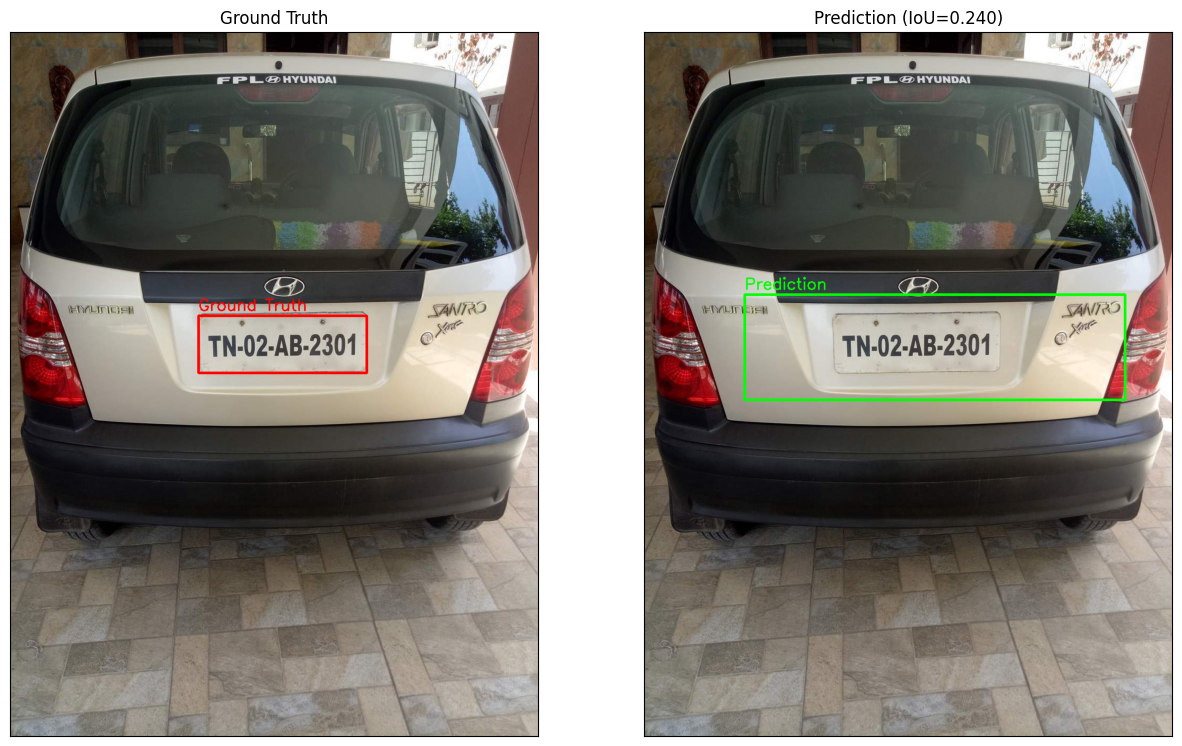

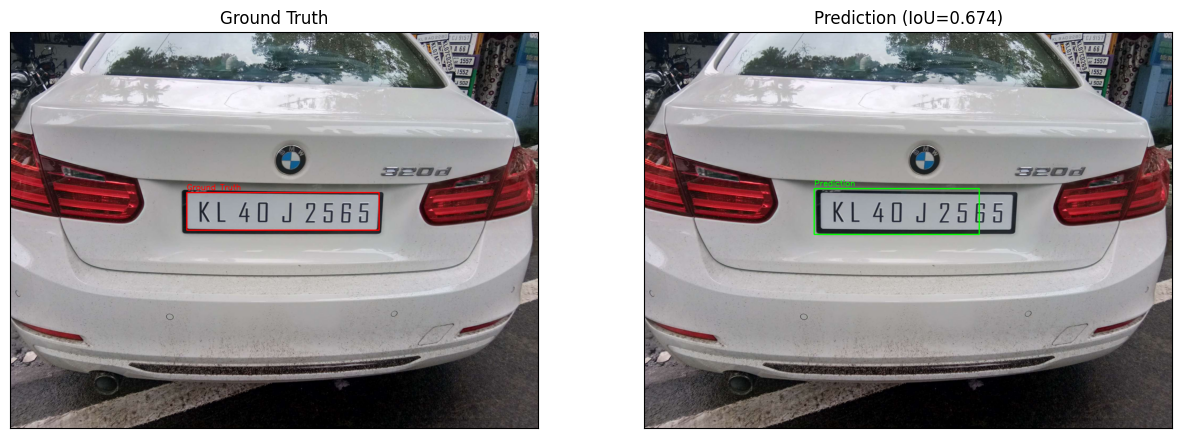

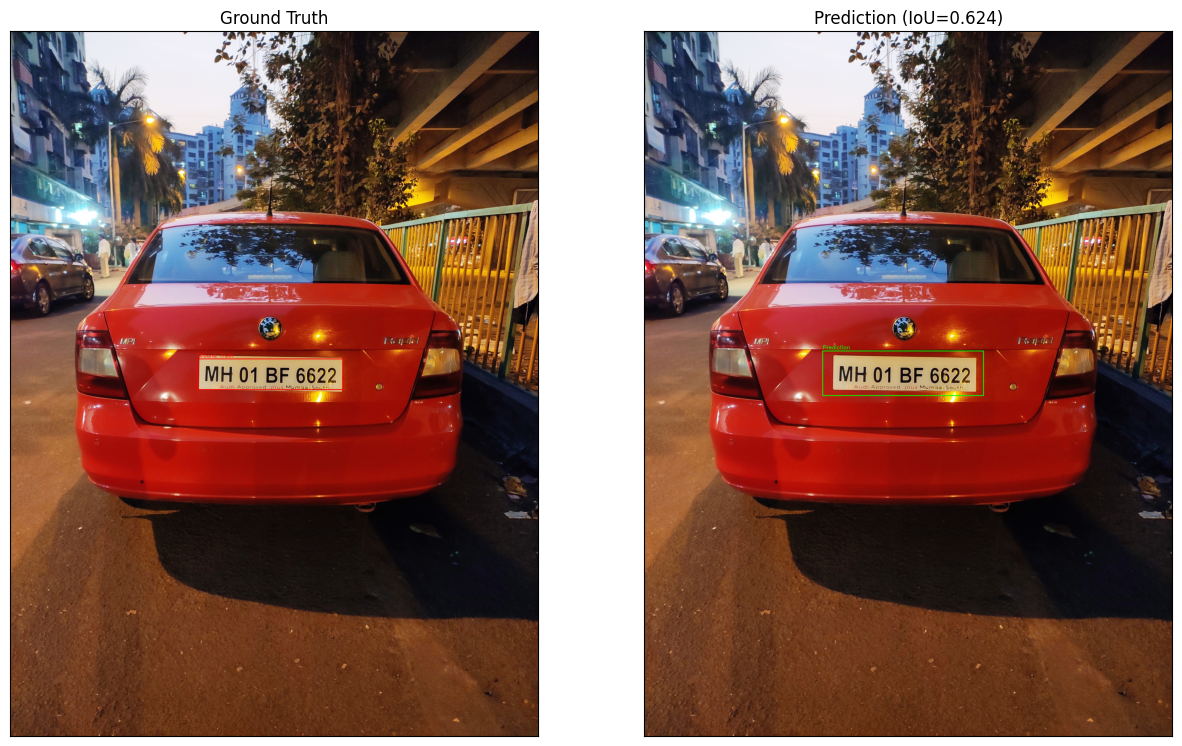

In [6]:
scales = np.linspace(0.5, 1.5,10)
threshold = 0.3
results = []


def image_read(image1, image2, title1="", title2=""):
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(121)
    ax1.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    ax1.set(xticks=[], yticks=[], title=title1)
    ax2 = fig.add_subplot(122)
    ax2.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
    ax2.set(xticks=[], yticks=[], title=title2)
    plt.show()

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou
#Loop dataset
for img_path in glob.glob(os.path.join(dataset_path, "*.*")):
    image = cv2.imread(img_path)
    if image is None:
        continue
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    filename = os.path.basename(img_path)

    best_score = -1
    best_box = None

    for scale in scales:
        tW = int(template.shape[1] * scale)
        tH = int(template.shape[0] * scale)
        if tW > gray.shape[1] or tH > gray.shape[0] or tW < 10 or tH < 10:
            continue

        tpl_scaled = cv2.resize(template, (tW, tH))
        result = cv2.matchTemplate(gray, tpl_scaled, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

        if max_val > best_score:
            best_score = max_val
            best_box = (max_loc[0], max_loc[1], tW, tH)

    plate_detected = image.copy()
    gt_image = image.copy()
    detected = False
    iou = 0

    # Kotak Ground Truth
    if filename in ground_truth:
        gx, gy, gw, gh = ground_truth[filename]
        cv2.rectangle(gt_image, (gx, gy), (gx+gw, gy+gh), (0,0,255), 3)
        cv2.putText(gt_image, "Ground Truth", (gx, gy-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    # Kotak Prediksi
    if best_box is not None and best_score >= threshold:
        x, y, w, h = best_box
        cv2.rectangle(plate_detected, (x, y), (x+w, y+h), (0,255,0), 3)
        cv2.putText(plate_detected, "Prediction", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        detected = True
        if filename in ground_truth:
            iou = compute_iou(best_box, ground_truth[filename])
        # Simpan crop plat
        crop_plate = image[y:y+h, x:x+w]
        cv2.imwrite(os.path.join(output_dir, f"crop_{filename}"), crop_plate)

    # Simpan hasil deteksi
    cv2.imwrite(os.path.join(output_dir, f"det_{filename}"), plate_detected)

    # Tampilkan hasil
    image_read(gt_image, plate_detected, "Ground Truth", f"Prediction (IoU={iou:.3f})")

    # Simpan hasil evaluasi
    results.append({"filename": filename, "detected": detected, "score": best_score, "IoU": iou})

# Evaluasi akhir
total = len(results)
correct = sum(1 for r in results if r["IoU"] >= 0.5)
avg_iou = np.mean([r["IoU"] for r in results if r["IoU"] > 0])
accuracy = correct / total if total > 0 else 0


In [7]:
print("\n=== HASIL EVALUASI ===")
for r in results:
    print(f"{r['filename']}: Detected={r['detected']}, Score={r['score']:.3f}, IoU={r['IoU']:.3f}")
print(f"\nAccuracy: {accuracy*100:.2f}%")
print(f"Average IoU: {avg_iou:.3f}")



=== HASIL EVALUASI ===
image1.jpg: Detected=True, Score=0.415, IoU=0.795
image3.jpg: Detected=True, Score=0.430, IoU=0.830
image4.jpg: Detected=True, Score=0.332, IoU=0.240
image5.jpg: Detected=True, Score=0.400, IoU=0.674
image2.jpg: Detected=True, Score=0.521, IoU=0.624

Accuracy: 80.00%
Average IoU: 0.633
